In [1]:
from langchain.agents import AgentType, initialize_agent
from langchain.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
import os
from uuid import uuid4

In [ ]:
import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=(""),
)

response = client.responses.create(
    model="gpt-3.5-turbo-1106",
    instructions="You are a coding assistant that talks like a pirate.",
    input="How do I check if a Python object is an instance of a class?",
)

print(response.output_text)

Arrr, to check if a Python object be an instance of a class, ye can use the `isinstance` function. Here be an example of how ye can use it:

```python
class Pirate:
    def __init__(self, name):
        self.name = name

pirate1 = Pirate("Blackbeard")
pirate2 = "Captain Hook"

print(isinstance(pirate1, Pirate))  # Output: True
print(isinstance(pirate2, Pirate))  # Output: False
```

Just pass the object and the class name to `isinstance` and it will tell ye if the object be an instance o' the class. Arrr!


In [ ]:
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup


import re

def limpiar_contenido(texto: str) -> str:
    # Quitar múltiples espacios y saltos de línea innecesarios
    texto = re.sub(r'\s+', ' ', texto)
    # Quitar créditos típicos como "AFP via Getty Images", etc.
    texto = re.sub(r'via Getty Images.*$', '', texto)
    # Eliminar encabezados de autor si no aportan contenido
    texto = re.sub(r'^[Bb]y\s+[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\s*', '', texto)
    # Quitar líneas muy cortas que parecen ser firmas o relleno
    texto = re.sub(r'\n.{1,10}\n', '\n', texto)
    # Recortar bordes
    return texto.strip()

def get_news(queries: str, page_size: int = 20, from_days: int = 7) -> dict:
    """
    Obtiene noticias relevantes de la API de NewsAPI y extrae el contenido de los artículos.

    :param queries: Palabras clave para buscar noticias.
    :param page_size: Número máximo de artículos a recuperar.

    :return: Un diccionario con los artículos relevantes y su contenido.
    """

    # Reemplaza con tu API key
    api_key = ""
    base_url = "https://newsapi.org/v2/"
    endpoint = "everything"  # Puedes cambiar esto por tus palabras clave
    sorted_by = "publishedAt"  # Puedes cambiar esto por tus palabras clave
    # Calcular la fecha de hace una semana (considerando la hora actual en Chile)
    now_cl = datetime.now()
    one_week_ago_cl = now_cl - timedelta(days=from_days)
    from_date = one_week_ago_cl.strftime("%Y-%m-%d")

    relevant_news = []
    for query in queries:
        url = f"{base_url}{endpoint}?q={query}&from={from_date}&pageSize={page_size}&sortedBy={sorted_by}&apiKey={api_key}"
        response = requests.get(url)
        data = response.json()

        if response.status_code == 200:
            articles = data.get("articles")
            if articles:
                print(f"Noticias de '{query}' desde {from_date} hasta hoy:")
                count = 0
                for article in articles:
                    article_url = article.get("url")
                    # print(f"Título: {article.get('title')}")
                    # print(f"URL: {article_url}")

                    # Intentar obtener el contenido del artículo con varios tags
                    content = ""
                    try:
                        article_response = requests.get(article_url)
                        article_response.raise_for_status()
                        soup = BeautifulSoup(article_response.text, 'html.parser')

                        possible_containers = [
                            'article',
                            'div.article-body',
                            'div.main',
                            'div.content',
                            'div.story',
                            'div[role="main"]',  # Buscar divs con el rol "main"
                            'section.article-content',
                            'section.main-content'
                        ]

                        for selector in possible_containers:
                            container = soup.select_one(selector)
                            if container:
                                content = '\n'.join([p.get_text() for p in container.find_all('p')])
                                if content.strip():  # Si encontramos contenido, detenemos la búsqueda
                                    break

                        if not content.strip():
                            # Si no se encontró un contenedor específico, extraer texto de todos los párrafos
                            content = '\n'.join([p.get_text() for p in soup.find_all('p')])

                        # print(f"Contenido:\n{content[:500]}..." if len(content) > 500 else f"Contenido:\n{content}") # Mostrar solo los primeros 500 caracteres para no saturar la salida

                    except requests.exceptions.RequestException as e:
                        # print(f"No se pudo obtener el artículo: {e}")
                        content = None  # No se pudo obtener el contenido
                    except AttributeError:
                        # print("No se pudo extraer el contenido del artículo (estructura HTML inesperada).")
                        content = None

                    if content:
                        count += 1
                        # print("news found!!!!")
                        # Guardar el artículo en el diccionario solo si se obtuvo contenido
                        
                        cleaned_content = limpiar_contenido(content)
                        cleaned_content = cleaned_content[:1250]  # Limitar el contenido a los primeros 2000 caracteres
                        
                        relevant_news.append({
                            "title": article.get("title"),
                            # "description": article.get("description"),
                            "content": cleaned_content,  
                            "source": article.get("source", {}).get("name", "Desconocido")
                        })
                    if count >= 4:
                        break
                                    
                print(f"Se encontraron {count} artículos relevantes para '{query}'.")
            else:
                print("No se encontraron noticias para los criterios especificados en la última semana.")
                content = None  # No se encontraron artículos
            
        else:
            print(f"Error al hacer la solicitud: {response.status_code}")
            print(f"Mensaje de error: {data.get('message')}")
    return relevant_news

In [3]:
from typing import List
from langchain.schema import Document

def index_news(noticias: List[dict], 
               path_indice: str = "./faiss_news_index/", 
               modelo_ollama: str = "nomic-embed-text",
               chequear_duplicados: bool = True) -> None:
    
    import hashlib, os
    from uuid import uuid4
    from langchain.vectorstores import FAISS
    from langchain.embeddings import OllamaEmbeddings
    from langchain.text_splitter import RecursiveCharacterTextSplitter


    
    print("Iniciando indexación de noticias...")
    embedding_model = OllamaEmbeddings(model=modelo_ollama)
    splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=40)

    def hash_text(text: str) -> str:
        return hashlib.md5(text.encode('utf-8')).hexdigest()

    if not noticias:
        print("No se encontraron noticias relevantes.")
        vectorstore = FAISS.load_local(path_indice, embedding_model, allow_dangerous_deserialization=True)
        return vectorstore



    # Extraer contenidos y metadatas primero
    contenidos, metadatas = [], []
    for noticia in noticias:
        contenido = noticia.get("content", "") or ""
        if contenido.strip() == "":
            continue
        contenidos.append(contenido)
        metadatas.append({
            "title": noticia.get("title", ""),
            "source": noticia.get("source", ""),
            "url": noticia.get("url", ""),
        })

    # Procesar en lote
    print("Dividiendo noticias en chunks...")
    documentos_nuevos = splitter.create_documents(contenidos, metadatas=metadatas)

    if not documentos_nuevos:
        print("No hay contenido útil para indexar.")
        return

    contenido_existente = set()

    # Cargar índice si existe
    if os.path.exists(path_indice):
        print("Cargando índice existente...")
        vectorstore = FAISS.load_local(path_indice, embedding_model, allow_dangerous_deserialization=True)
        if chequear_duplicados:
            documentos_existentes = vectorstore.docstore._dict.values()
            contenido_existente = set(hash_text(doc.page_content) for doc in documentos_existentes)
    else:
        print("Creando nuevo índice FAISS...")
        vectorstore = FAISS.from_documents(documentos_nuevos, embedding_model)

    # Filtrar duplicados
    print("Filtrando duplicados...")
    if chequear_duplicados:
        documentos_para_agregar = [doc for doc in documentos_nuevos if hash_text(doc.page_content) not in contenido_existente]
    else:
        documentos_para_agregar = documentos_nuevos

    if not documentos_para_agregar:
        print("Las noticias ya estaban indexadas. No se agregaron documentos nuevos.")
        return vectorstore

    ids = [str(uuid4()) for _ in documentos_para_agregar]

    print(f"Agregando {len(documentos_para_agregar)} documentos al índice...")
    vectorstore.add_documents(documents=documentos_para_agregar, ids=ids)

    vectorstore.save_local(path_indice)
    print(f"Índice actualizado con {len(documentos_para_agregar)} nuevas noticias.")
    return vectorstore


In [4]:
def generate_initial_portfolio() -> list:
    portfolio = [
        "Equity Tech Fund"
        "Green Energy ETF",
        "Health Bio Stocks",
        "Global Bonds Fund",
        "CryptoIndex",
        "Real Estate REIT",
        "Emerging Markets Fund",
        "AI & Robotics ETF",
        "Commodities Basket"    
        ]
    return portfolio


nodo 1

In [5]:
def nodo_1_generar_portafolio_inicial(state: dict = None) -> dict:
    """
    Nodo 1: Bienvenida y generación del portafolio inicial con distribución fija.
    """
    tickers = generate_initial_portfolio()
    mensaje_bienvenida = (
        "¡Bienvenido al asistente de inversiones!\n"
        "Hemos generado un portafolio inicial diversificado basado en diferentes sectores del mercado."
    )

    return{
        **state,
        "tickers": tickers, # Excluyendo 'Cash Reserve'
        "mensaje": mensaje_bienvenida
    }


In [6]:
def nodo_2_indexar_noticias(state: dict) -> dict:
    # 1. Generar cartera inicial (puedes parametrizar por monto total)
    portfolio = {
        "Equity Tech Fund": 0.20,
        "Green Energy ETF": 0.15,
        "Health Bio Stocks": 0.10,
        "Global Bonds Fund": 0.10,
        "CryptoIndex": 0.10,
        "Real Estate REIT": 0.10,
        "Emerging Markets Fund": 0.10,
        "AI & Robotics ETF": 0.05,
        "Commodities Basket": 0.05,
        "Cash Reserve": 0.05
    }
    # 2. Extraer tickers/sectores de la cartera
    tickers = [asset for asset in portfolio]

    # 3. Obtener noticias desde NewsAPI
    news_data = get_news(tickers, from_days=20)
    print("news_data", news_data)

    # 4. Indexar en vectorstore con embeddings (incluye metadata)
    vectorstore = index_news(news_data)
    print("vectorstore", vectorstore)

    return {
        **state,
        "portfolio": portfolio,
        "vectorstore": vectorstore,
        "mensaje": "Noticias indexadas exitosamente. Puedes revisar el portafolio o buscar información adicional.",
    }


In [7]:
def nodo_3_pedir_accion_usuario(state: dict) -> dict:
    """
    Nodo 3:Pregunta al usuario qué acción desea realizar.
    """
    mensaje = (
        "¿Qué acción te gustaría realizar? Escribe una opción o número\n"
        "1. Actualizar Noticias\n"
        "2. Conversar\n"
        "3. Rebalancear Portafolio\n")
    while 1:
        user_action = str(input(mensaje))

        if user_action == "1" or user_action.lower() == "actualizar noticias":
            action = "actualizar noticias"
            break
        elif user_action == "2" or user_action.lower() == "conversar":
            action = "hacer preguntas"
            break
        elif user_action == "3" or user_action.lower() == " rebalancear portafolio":
            action = "sugerir rebalanceo"
            break
        else:
            action = None
            print("Acción no válida. Por favor, elige una opción válida.")
        print("action", action)
    return {
        **state,
        "mensaje": mensaje,
        "next_action": action,  # next_action indica siguiente paso
    }

In [8]:
def nodo_4_actualizar_noticias_por_sector(state: dict, sector: str) -> dict:
    pass



In [9]:
# from langchain.agents import initialize_agent, AgentType
# from langchain.tools import Tool
# from langchain.llms import Ollama
# from langchain.vectorstores import FAISS
# from langchain.embeddings import OllamaEmbeddings


# embeddings = OllamaEmbeddings(model="nomic-embed-text")
# # Cargar tu vectorstore (ya previamente indexado)
# db = FAISS.load_local("faiss_news_index", embeddings=embeddings, allow_dangerous_deserialization=True)

# retriever = db.as_retriever()

# def buscar_contexto(query: str) -> str:
#     docs = retriever.get_relevant_documents(query)
#     return "\n\n".join([doc.page_content for doc in docs])

# herramienta_busqueda = Tool(
#     name="BuscadorNoticias",
#     func=buscar_contexto,
#     description="Usa esto para buscar información en las noticias indexadas."
# )

# llm = Ollama(model="mistral:7b")

# prompt = (
#     "Eres un asistente de inversiones. Tu tarea es responder preguntas sobre el portafolio y las noticias relacionadas. "
#     "Si saluda o se despide, responde de manera amigable y finaliza la conversacion."
#     "Si el usuario dice algo incoherente o irrelevante, responde con un mensaje amigable y sugiere que haga preguntas sobre el portafolio o las noticias."
# )

# agent = initialize_agent(
#     tools=[herramienta_busqueda],
#     llm=llm,
#     agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
#     # verbose=True,
#     # prompt=prompt,
#     handle_parsing_errors=True,
#     max_iterations=3,

# )

# def nodo_5_responder_dudas(state: dict) -> dict:
#     input_message = input("Escribe tu pregunta: ")
#     if input_message.lower() == "opciones" or input_message.lower() == "o":
#         return {
#             **state,
#             "next_action": "opciones",
#     }

#     result = agent.invoke(input_message)
#     print("Respuesta del agente:", result)


#     return {
#         **state,
#         "mensaje": result,
#         "next_action": "hacer preguntas",
#     }


In [10]:
from langchain.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.tools import Tool
from langchain.agents import create_react_agent, AgentExecutor
from langchain.vectorstores import FAISS
from langchain.embeddings import OllamaEmbeddings

# Paso 1: Configurar el vectorstore como herramienta de búsqueda
embeddings = OllamaEmbeddings(model="nomic-embed-text")
db = FAISS.load_local("faiss_news_index", embeddings=embeddings, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

def buscar_contexto(query: str) -> str:
    docs = retriever.get_relevant_documents(query)
    return "\n\n".join([doc.page_content for doc in docs])

herramienta_busqueda = Tool(
    name="BuscadorNoticias",
    func=buscar_contexto,
    description="Usa esto para buscar información en las noticias indexadas."
)

# Paso 2: Crear el LLM y el prompt personalizado
llm = Ollama(model="mistral")

prompt = PromptTemplate.from_template("""
You are a helpful and knowledgeable financial assistant. Your job is to help the user understand their investment portfolio and stay updated with relevant news in the financial markets.

You have access to the following tools:
{tools}

You must follow **strictly** the following format to reason and act:

---
Question: {input}
Thought: (What do you need to consider or figure out?)
Action: (Choose exactly one from [{tool_names}])
Action Input: (What do you want to search or query?)
Observation: (Result of the action/tool)
... (Repeat Thought/Action/Action Input/Observation if needed)
Thought: (Summarize what you learned and confirm you're ready to respond)
Final Answer: (Your complete and final response to the user)
---

Additional rules:
- Never include both a Final Answer and an Action in the same step.
- If the user just greets, respond kindly without using any tools.
- If no action is needed, go directly to the Final Answer, but only after a clear Thought step.
- Only use tools when needed to answer the question accurately.

Begin!

Question: {input}
{agent_scratchpad}
""")



# Paso 3: Crear el agente y su ejecutor
react_agent = create_react_agent(
    llm=llm,
    tools=[herramienta_busqueda],
    prompt=prompt,
    
)

agent_executor = AgentExecutor(agent=react_agent, tools=[herramienta_busqueda],handle_parsing_errors="Check your output and make sure it conforms! Do not output an action and a final answer at the same time.",max_iterations=5, verbose=True)

def nodo_5_responder_dudas(state: dict) -> dict:
    input_message = input("Escribe tu pregunta (o 'opciones' para volver): ")

    if input_message.lower() in ["opciones", "o"]:
        return {
            **state,
            "next_action": "opciones"
        }

    result = agent_executor.invoke({"input": input_message})
    print("\n🧠 Respuesta del asistente:", result)

    return {
        **state,
        "mensaje": result,
        "next_action": "hacer preguntas",
    }



C:\Users\piery\AppData\Local\Temp\ipykernel_44300\930015236.py:9: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(model="nomic-embed-text")
C:\Users\piery\AppData\Local\Temp\ipykernel_44300\930015236.py:24: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="mistral")


In [11]:
def nodo_6_rebalanceo_recomendado(state: dict) -> dict:
    # """
    # Nodo 6: Rebalanceo recomendado por el agente.
    # """

    # embeddings = OllamaEmbeddings(model="nomic-embed-text")
    # # Cargar tu vectorstore (ya previamente indexado)
    # db = FAISS.load_local("faiss_news_index", embeddings=embeddings, allow_dangerous_deserialization=True)

    # retriever = db.as_retriever()

    # def buscar_contexto(query: str) -> str:
    #     docs = retriever.get_relevant_documents(query)
    #     return "\n\n".join([doc.page_content for doc in docs])

    # herramienta_busqueda = Tool(
    #     name="BuscadorNoticias",
    #     func=buscar_contexto,
    #     description="Usa esto para buscar información en las noticias indexadas."
    # )

    # llm = Ollama(model="mistral:7b")

    # prompt = (
    #     "Eres un inversionista experto. Tu tarea es sugerir un rebalanceo de portafolio basado en las noticias recientes y el contexto del mercado. "
    # )

    # agent = initialize_agent(
    #     tools=[herramienta_busqueda],
    #     llm=llm,
    #     agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    #     # verbose=True,
    #     prompt=prompt,
    #     handle_parsing_errors=True,
    #     max_iterations=3,



    # return {
    #     **state,
    #     "mensaje": "Rebalanceo recomendado: 10% en cada sector.",
    #     "next_action": "fasfas",
    # }
    pass

In [12]:
def nodo_7_aceptar_rechazar_rebalanceo(state: dict) -> dict:
    pass

In [13]:
def nodo_8_procesar_decision_rebalanceo(state: dict) -> dict:
    pass

In [14]:
def nodo_9_generar_reporte(state: dict) -> dict:
    pass


In [15]:
def nodo_10_continuar_o_finalizar(state: dict) -> dict:
    pass

In [16]:
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import BaseMessage
from langchain_core.agents import AgentAction
from typing import Annotated
import operator

# Define el estado (puedes agregar más atributos según lo que uses)
from typing_extensions import TypedDict
 
class State(TypedDict):
    portfolio: dict
    tickers: list
    vectorstore: object
    messages: Annotated[list[BaseMessage], operator.add]
    next_action: str


# Construcción del workflow
workflow = StateGraph(State)

# Añadir nodos con los nombres definidos
workflow.add_node("nodo_1_generar_portafolio_inicial", nodo_1_generar_portafolio_inicial)
workflow.add_node("nodo_2_indexar_noticias", nodo_2_indexar_noticias)
workflow.add_node("nodo_3_pedir_accion_usuario", nodo_3_pedir_accion_usuario)
# workflow.add_node("nodo_4_actualizar_noticias_por_sector", nodo_4_actualizar_noticias_por_sector)
workflow.add_node("nodo_5_responder_dudas", nodo_5_responder_dudas)
workflow.add_node("nodo_6_rebalanceo_recomendado", nodo_6_rebalanceo_recomendado)
workflow.add_node("nodo_7_aceptar_rechazar_rebalanceo", nodo_7_aceptar_rechazar_rebalanceo)
workflow.add_node("nodo_8_procesar_decision_rebalanceo", nodo_8_procesar_decision_rebalanceo)
workflow.add_node("nodo_9_generar_reporte", nodo_9_generar_reporte)
workflow.add_node("nodo_10_continuar_o_finalizar", nodo_10_continuar_o_finalizar)

workflow.set_entry_point("nodo_1_generar_portafolio_inicial")


# Edges: conectar nodos
workflow.add_edge(START, "nodo_1_generar_portafolio_inicial")
workflow.add_edge("nodo_1_generar_portafolio_inicial", "nodo_2_indexar_noticias")
workflow.add_edge("nodo_2_indexar_noticias", "nodo_3_pedir_accion_usuario")

workflow.add_conditional_edges(
    "nodo_3_pedir_accion_usuario",
    lambda state: state["next_action"],  # next_action indica siguiente paso
    {
        "actualizar noticias": "nodo_2_indexar_noticias",
        "hacer preguntas": "nodo_5_responder_dudas",
        "sugerir rebalanceo": "nodo_6_rebalanceo_recomendado",
    },
)

workflow.add_conditional_edges(
    "nodo_5_responder_dudas",
    lambda state: state["next_action"],  # next_action indica siguiente paso
    {
        "opciones": "nodo_3_pedir_accion_usuario",
        "hacer preguntas": "nodo_5_responder_dudas",
    },
)


workflow.add_edge("nodo_6_rebalanceo_recomendado", "nodo_7_aceptar_rechazar_rebalanceo")

workflow.add_conditional_edges(
    "nodo_7_aceptar_rechazar_rebalanceo",
    # lambda state: "aplicar" if state.get("rebalance_accepted") else None,
    lambda state: state["next_action"],  # next_action indica siguiente paso
    {
        "aplicar": "nodo_8_procesar_decision_rebalanceo",
        "rechazar": "nodo_3_pedir_accion_usuario"
    },
)

workflow.add_edge("nodo_8_procesar_decision_rebalanceo", "nodo_9_generar_reporte")
workflow.add_edge("nodo_9_generar_reporte", "nodo_10_continuar_o_finalizar")


workflow.add_conditional_edges(
    "nodo_10_continuar_o_finalizar",
    lambda state: "continuar" if state.get("continue_investing") else "finalizar",
    {
        "continuar": "nodo_3_pedir_accion_usuario",  # vuelve a indexar nuevas noticias
        "finalizar": END,
    }
)

# Compilar

graph = workflow.compile()


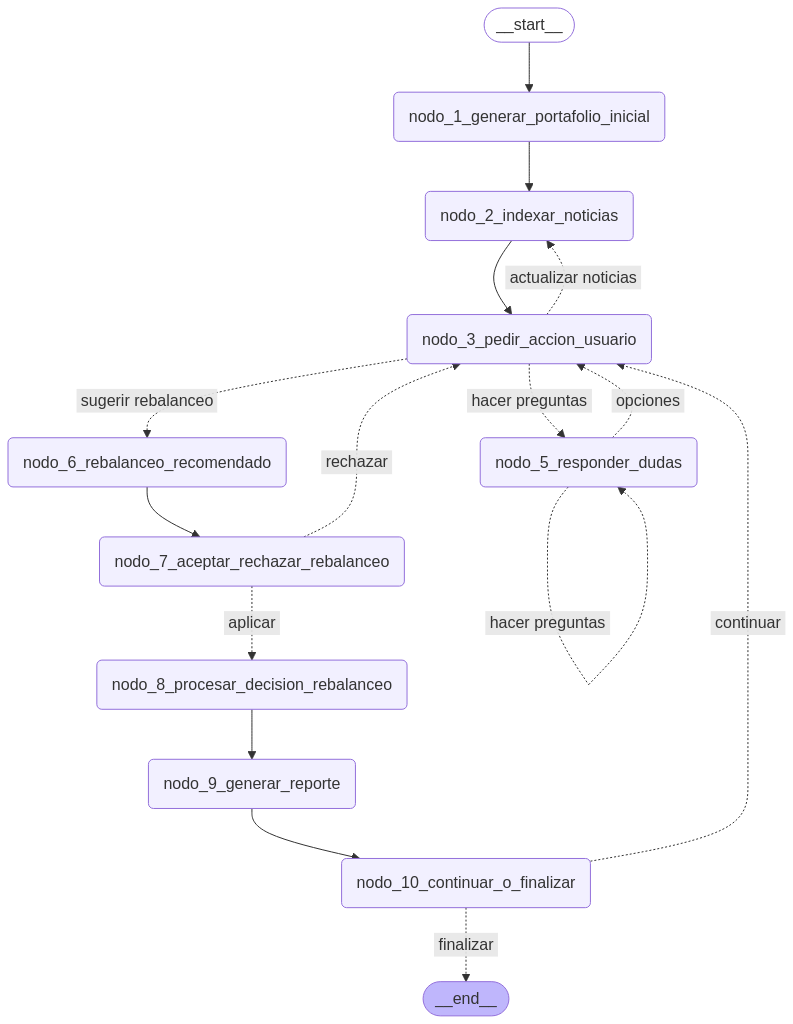

In [17]:
graph.step_timeout = 60 * 60 * 24  # 24 horas
graph

In [18]:
initial_state = {
    "portfolio": {},
    "tickers": [],
    "vectorstore": None,
    "message": "",
    "next_action": None,
    
}

final_state = graph.invoke(initial_state)
print("Final state:")
print(final_state)



Error al hacer la solicitud: 429
Mensaje de error: You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.
Error al hacer la solicitud: 429
Mensaje de error: You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.
Error al hacer la solicitud: 429
Mensaje de error: You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.
Error al hacer la solicitud: 429
Mensaje de error: You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a p

KeyError: 'sugerir rebalanceo'